# Image Segmentation with Simulated Annealing

This notebook describes the implementation of an image segmentation algorithm, which utilizes the probabilistic technique simulated annealing. The main focus is the actual implementation in python for an image of the shape 254x333.

The initial informations are the following:

- A magnetic resonance image from a brain where each pixel has a unique value on a gray scale. This data is provided in the file "SimMRimage.dat"

- Based on the gray value of a pixel it can be classified into four different brain tissues or background: Background (BG), White Matter (WM), Gray Matter (GM), Cerebrospinal Fluid (CSF) and Skullbone (SB). 

- Each tissues gray scale follows a normal distribution with given mean and standard deviation.

## Details on Simulated Annealing

### Introduction

Simulated Annealing is a metaheuristic approach on finding an approximation for a global maximum in a large search space for an optimization problem. It is used when finding an approximation to a global maximum is more important to precisely finding a local optimum in a fixed amount of time.

The name stems from annealing in metallurgy, a technique involving heating an controlled cooling in order to alter its properties. The notion of slow cooling implemented in simulated annealing is interpreted as a slow decrease in the probability of accepting worse solutions as the solution space is explored. Accepting worse solutions allows for a more extensive search for the global optimal solution. 

In order to apply the simulated annealing method to a specific problem, one must specify the following parameters:

- the state space
- the energy (goal) function 
- the candidate generator procedure (neighbours)
- the acceptance probabilty function
- the annealing schedule (temperature)

These choices can have a significant impact on the method's effectiveness. Unfortunately, there are no choices of these parameters that will be good for all problems, and there is no general way to find the best choices for a given problem.


### Choice of Parameter

This section provides the choice of parameters:
* state space: It is represented by a pixel grid with shape 254x333.

* neigbours: Standing on a given pixel the four nearest neighbours contribute to the energy function.

* energy function H: 
$$ H(\sigma_i) = -J \sum_{<ij>}\delta_{\sigma_i,\sigma_j} + \sum_i \frac{(z_i-\bar{z}_{\sigma_i})^2}{2\Sigma_{\sigma_i}^2}+ln(\Sigma_{\sigma_i})$$


where: <br/> <br/>
${z_i}$ is the MRI intensity of the i-th pixel<br/> <br/>
$\sigma_i \in (BG,WM,GM,CSF,BS)$  gives the tissue value of the i-th pixel encoded from 0 to 4 <br/><br/>
$J$ is a measure of how much the neighbours affect the energy since having a neighbour with the same tissue increases the probability of being this tissue. The second and third term stems from the nature of the intensity distribution of the MRI.<br/><br/>
* acceptance probability: Boltzmann-statistic
$$ P(\sigma | z) \sim e^{-H(\sigma)/T} $$
* temperature schedule: was found via trial and error

## Implementation

### Step 1: Loading the requiered libraries:

In [30]:
import numpy as np
import time
import datetime
import random as rd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

### Step 2: Loading the initial data into variables:

In [31]:
#image shape
Nimax = 254
Njmax = 333

#intensity statistics of the different tissues      
#        BG, WM, GM, CSF, BS
mean = [30,426,602,1223,167]
std = [30,59,102,307,69]

#intesity values of each pixel
mr = np.loadtxt("SimMRimage.dat")[:,2].reshape(Nimax,Njmax)

### Step 3: Randomly assigning a tissue to each pixel of a grid:

In [32]:
def random_init(array):
    for i in range(0,Nimax):
        for j in range(0,Njmax):
            array[i][j] = int(rd.uniform(0,5))

random_grid = np.zeros(shape=(Nimax, Njmax))
random_init(random_grid)

### Step 4: Create a function which calculates the energy of a given pixel with periodic boundary conditions for the neighbours:

In [33]:
def energy(J,grey_vals, mean, std, init_grid, k,l):
    E = 0

    #Summation over 4 neighboars
    for i in [0,2]:
        for o in [0,2]:
            Inew = k + 2 - i
            Jnew = l + 2 - o
            if Inew <= 0:
                Inew=Nimax-1
            else:
                if Inew>= Nimax:
                    Inew=0
            if Jnew <= 0:
                Jnew=Njmax-1
            else:
                if Jnew>= Nimax:
                    Jnew=0
            
            #energy contribution of equal neighbours
            if init_grid[Inew][Jnew] == init_grid[k][l]:
                E = E-J

    #calculate energy
    E=E+(grey_vals[k][l]-mean[int(init_grid[k][l])])**2/(2*(std[int(init_grid[k][l])])**2)+np.log(std[int(init_grid[k][l])])
    return E

### Step 5: Creating the simulated annealing algorithm:

1. defining the cooling schedule

2. defining how often the whole grid should be sweeped at a given temperature

3. looping through the grid with sweeping process:

      3.1 calculate the energy of the pixel you are currently at

      3.2 swap the pixel with a random tissue

      3.3 calculate the energy of the swaped pixel

      3.4 calculate the acceptance probability of the energy difference between the orginal tissue and the swaped one

      3.5 if the acceptance probability is smaller than a random value between zero and one you stay with the initial tissue, else you take the swapped one. Therefore there is a chance that we swap, despite the energy is not minimized in doing so. 
 

In [34]:
def sim_annealing():
    steps = 10
    T=3*1.2
    J_0 = 1
    dT = 2/steps
    E = 0
    rounds = 500
    start = time.time()
    for o in np.arange(steps, 0,-1):

        #slowly decreasing the temperature
        T=T/1.2

        #sweeping at Temperature T
        for n in np.arange(1,rounds*o/steps):

            #looping through all pixels 
            for i in np.arange(0,Nimax):
                for j in np.arange(0,Njmax):

                    #calculate the energies of the pixel and the swaped one
                    E1 = energy(J_0,mr,mean, std, random_grid, i, j)
                    help_grid = random_grid[i][j]
                    random_grid[i][j] = int(rd.uniform(0,5))
                    E2 = energy(J_0, mr, mean, std, random_grid, i, j)

                    #calculate the acceptance probabilty
                    delta_E = E2 - E1
                    if delta_E/T >= 20:
                        r = 0
                    else:
                        if delta_E/T <=0.05:
                            r=1
                        else:
                            r=np.exp(-delta_E/T)
                    
                    #decide if you swap or stay
                    if r < rd.uniform(0,1):
                        random_grid[i][j] = help_grid

    end = time.time()
    print("duration:", time.strftime("%H:%M:%S", time.gmtime(end-start)))

### Step 6: Executing the algorithm:

In [35]:
sim_annealing()

duration: 00:49:49


### Step 7: Visualizing the results:

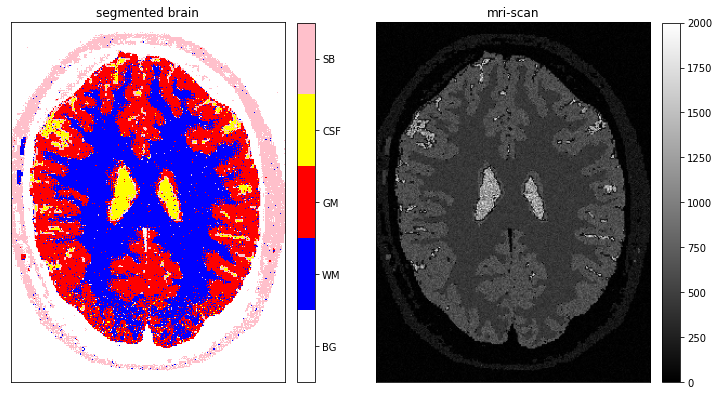

In [36]:
plot_array = random_grid.reshape(Nimax, Njmax)
cmap, norm = mcolors.from_levels_and_colors([0, 1, 2, 3, 4, 5], ['white', 'blue', 'red', "yellow", "pink"])

fig, ax = plt.subplots(1,2, figsize=(12,12))
plot1 = ax[0].imshow(plot_array.T, interpolation="nearest",cmap=cmap, vmin=-0.5, vmax=4.5,)
ax[0].set_title("segmented brain")
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])

cb1 = plt.colorbar(plot1,ticks=[0,1,2,3,4], ax=ax[0], fraction=0.059, pad=0.04)
cb1.set_ticklabels(["BG","WM","GM","CSF","SB"])


plot2 = ax[1].imshow(mr.T, cmap="gray")
ax[1].set_title("mri-scan")
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])

cb2 = plt.colorbar(plot2, ax=ax[1], fraction=0.059, pad=0.04)